In [1]:
from coffea.nanoevents import NanoEventsFactory
import awkward as ak
import numpy as np
import hist
import pandas as pd
import uproot
import json
import glob
import matplotlib.pyplot as plt

In [2]:
from correctionlib.schemav2 import CorrectionSet, Correction, Variable
from correctionlib.convert import from_histogram
import correctionlib

def evaluator(corr):
    cset = CorrectionSet(schema_version=2, corrections=[corr])
    return np.vectorize(
        correctionlib.CorrectionSet(cset)[corr.name].evaluate,
    )

vptvar = Variable(
    name="hpt",
    type="real",
    description="Generated Higgs boson pT"
)

In [3]:
# https://arxiv.org/pdf/2005.07762.pdf
# Inclusive pT bins
theory_xs = {}
xs_ewkcorr = {}

ptmin = np.array([400,450,500,550,600,650,700,750,800,1200])

theory_xs['VBF'] = np.array([14.23,8.06,4.75,2.90,1.82,1.17,0.77,0.51,0.35])
xs_ewkcorr['VBF'] = np.array([-17.80,-19.43,-21.05,-22.34,-23.73,-25.03,-26.29,-27.35,-28.42])*0.01

theory_xs['VH'] = np.array([11.16,6.87,4.39,2.87,1.91,1.30,0.90,0.62,0.44])
xs_ewkcorr['VH'] = np.array([-19.05,-20.83,-22.50,-24.07,-25.56,-26.98,-28.30,-29.60,-30.83])*0.01

theory_xs['ttH'] = np.array([6.89,4.24,2.66,1.76,1.11,0.72,0.47,0.32,0.22])
xs_ewkcorr['ttH'] = np.array([-6.95,-7.75,-8.49,-9.11,-9.91,-10.67,-11.37,-11.94,-12.51])*0.01

In [5]:
# apply the EW corrections
def ew_xs(xs,corr):
    return np.multiply(xs,1+corr)

# Make the bins exclusive
def make_excl(th):
    excl = -1*np.diff(th)
    return np.append(excl,[th[-1]])

In [6]:
def binning(idx, shift):
    epsilon = np.zeros(113)
    epsilon[idx] = shift
    return {
        "nodetype": "binning",
        "input": "vpt",
        "edges": list(vptproc.edges),
        "content": list(evj_qcd(epsilon) / den),
        "flow": "clamp",
    }

Without EW corr [6.17 3.31 1.85 1.08 0.65 0.4  0.26 0.16 0.35]
With EW corr [5.203118 2.743817 1.497985 0.864026 0.510965 0.309582 0.197052 0.119985
 0.25053 ]
Weights [0.84329303 0.82894773 0.80972162 0.80002407 0.7861     0.773955
 0.75789231 0.74990625 0.7158    ]


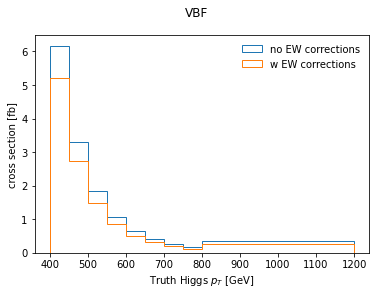

In [7]:
p = 'VBF'
noewcorr = make_excl(theory_xs[p])
yesewcorr = make_excl(ew_xs(theory_xs[p],xs_ewkcorr[p]))
print('Without EW corr',noewcorr)
print('With EW corr',yesewcorr)

weights = np.divide(yesewcorr,noewcorr)
print('Weights',weights)

VBF_EW = Correction(
    name="VBF_EW",
    version=1,
    description="Electroweak correction to VBF Higgs production",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "hpt",
        "edges": list(ptmin),
        "content": list(weights),
        "flow": "clamp",
    },
)

plt.hist(x=ptmin[:-1],weights=noewcorr,bins=ptmin,histtype='step',label='no EW corrections')
plt.hist(x=ptmin[:-1],weights=yesewcorr,bins=ptmin,histtype='step',label='w EW corrections')
plt.legend(frameon=False)
plt.suptitle(p);
plt.xlabel(r'Truth Higgs $p_{T}$ [GeV]');
plt.ylabel('cross section [fb]');

Without EW corr [4.29 2.48 1.52 0.96 0.61 0.4  0.28 0.18 0.44]
With EW corr [3.595041 2.036729 1.223059 0.757387 0.472544 0.30396  0.20882  0.132132
 0.304348]


Text(0, 0.5, 'cross section [fb]')

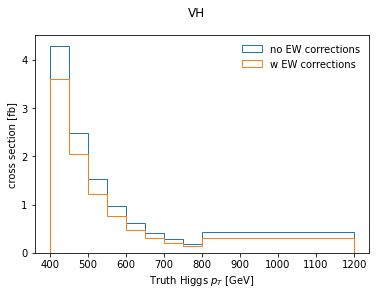

In [8]:
p = 'VH'
noewcorr = make_excl(theory_xs[p])
yesewcorr = make_excl(ew_xs(theory_xs[p],xs_ewkcorr[p]))
print('Without EW corr',noewcorr)
print('With EW corr',yesewcorr)

VH_EW = Correction(
    name="VH_EW",
    version=1,
    description="Electroweak correction to VH Higgs production",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "hpt",
        "edges": list(ptmin),
        "content": list(weights),
        "flow": "clamp",
    },
)

plt.hist(x=ptmin[:-1],weights=noewcorr,bins=ptmin,histtype='step',label='no EW corrections')
plt.hist(x=ptmin[:-1],weights=yesewcorr,bins=ptmin,histtype='step',label='w EW corrections')
plt.legend(frameon=False)
plt.suptitle(p)
plt.xlabel(r'Truth Higgs $p_{T}$ [GeV]')
plt.ylabel('cross section [fb]')

Without EW corr [2.65 1.58 0.9  0.65 0.39 0.25 0.15 0.1  0.22]
With EW corr [2.499745 1.477234 0.834502 0.599665 0.356823 0.226615 0.134769 0.089314
 0.192478]


Text(0, 0.5, 'cross section [fb]')

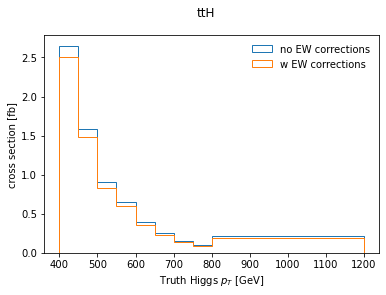

In [9]:
p = 'ttH'
noewcorr = make_excl(theory_xs[p])
yesewcorr = make_excl(ew_xs(theory_xs[p],xs_ewkcorr[p]))
print('Without EW corr',noewcorr)
print('With EW corr',yesewcorr)

ttH_EW = Correction(
    name="ttH_EW",
    version=1,
    description="Electroweak correction to ttH Higgs production",
    inputs=[vptvar],
    output=Variable(name="out", type="real", description="Multiplicative k-factor"),
    data={
        "nodetype": "binning",
        "input": "hpt",
        "edges": list(ptmin),
        "content": list(weights),
        "flow": "clamp",
    },
)

plt.hist(x=ptmin[:-1],weights=noewcorr,bins=ptmin,histtype='step',label='no EW corrections')
plt.hist(x=ptmin[:-1],weights=yesewcorr,bins=ptmin,histtype='step',label='w EW corrections')
plt.legend(frameon=False)
plt.suptitle(p)
plt.xlabel(r'Truth Higgs $p_{T}$ [GeV]')
plt.ylabel('cross section [fb]')

In [10]:
cset = CorrectionSet(
    schema_version=2,
    corrections=[VBF_EW, VH_EW, ttH_EW]
)

import rich

rich.print(cset)
with open("EWHiggsCorrections.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

CorrectionSet (schema v2)
No description
📂
├── 📈 VBF_EW (v1)
│   Electroweak correction to VBF Higgs production
│   Node counts: Binning: 1
│   ╭────────────── ▶ input ──────────────╮
│   │ hpt (real)                          │
│   │ Generated Higgs boson pT            │
│   │ Range: [400.0, 1200.0), overflow ok │
│   ╰─────────────────────────────────────╯
│   ╭─────── ◀ output ────────╮
│   │ out (real)              │
│   │ Multiplicative k-factor │
│   ╰─────────────────────────╯
├── 📈 VH_EW (v1)
│   Electroweak correction to VH Higgs production
│   Node counts: Binning: 1
│   ╭────────────── ▶ input ──────────────╮
│   │ hpt (real)                          │
│   │ Generated Higgs boson pT            │
│   │ Range: [400.0, 1200.0), overflow ok │
│   ╰─────────────────────────────────────╯
│   ╭─────── ◀ output ────────╮
│   │ out (real)              │
│   │ Multiplicative k-factor │
│   ╰─────────────────────────╯
└── 📈 ttH_EW (v1)
    Electroweak correction to ttH Higgs production
    Node counts: Binning: 1
    ╭────────────── ▶ input ──────────────╮
    │ hpt (real)                          │
    │ Generated Higgs boson pT            │
    │ Range: [400.0, 1200.0), overflow ok │
    ╰─────────────────────────────────────╯
    ╭─────── ◀ output ────────╮
    │ out (real)              │
    │ Multiplicative k-factor │
    ╰─────────────────────────╯